# Video classification with Tensorflow

- Downloading Dataset - UCF101
- Trimming Dataset videos
- Dataset Preprocessing
- Model creation
- Model training
- Testing on test data
- Save and download model
- Inference code for testing on single Video


# Downloading Dataset


## Imports

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import random
import ssl
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request
import re
import tempfile
import pandas as pd
from keras import backend as K
import sys
import csv
import os
import cv2
import math
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from google.colab import drive
import gc

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Define root paths accordingly


In [3]:
data_root = '/content/drive/MyDrive/video_classification_exercise_1/dataset/'
folder_root = '/content/drive/MyDrive/video_classification_exercise_1/'

## Mount drive

In [5]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Add the video classnames you want to finetune the pretrained model with!

In the list v, add the classnames of the videos you want to fine tune on. We take 5 classes of exercise. A possible use case of this could be recording number of minutes spent execising. We all know how during execising a lot of people start using their phones and get unfocused. If duration of non exercise activity exceeds a threshold, say 30 secs, an sound can alert the user that they have stopped and must get back to exercising.

In [ ]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
Videos ={}
_CACHE_DIR = tempfile.mkdtemp()
unverified_context = ssl._create_unverified_context()
os.mkdir(folder_root)
os.mkdir(data_root)
v = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps'] # make changes here to use different video classes
for classname in v:
  os.mkdir(data_root+classname)
print('The directory structure is created is created.')
def list_ucf_videos():
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")

    for i in v:
      s = "(v_"+str(i)+"[\w_]+\.avi)"
      videos = re.findall(s, index)
      Videos[i]=sorted(set(videos))
  return Videos

The directory structure is created is created.


In [ ]:
unverified_context = ssl._create_unverified_context()
def fetch_ucf_video(video):
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

In [ ]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"

V={}
unverified_context = ssl._create_unverified_context()
V = list_ucf_videos()
for i,value in V.items():
  _VIDEO_LIST = V[i]
  _CACHE_DIR = "/content/drive/MyDrive/video_classification_exercise_1/dataset/" + str(i) + "/"
  for j in _VIDEO_LIST:
    video_path = fetch_ucf_video(j)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PullUps_g18_c01.avi => /content/drive/MyDrive/video_classification_exercise_1/dataset/PullUps/v_PullUps_g18_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PullUps_g18_c02.avi => /content/drive/MyDrive/video_classification_exercise_1/dataset/PullUps/v_PullUps_g18_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PullUps_g18_c03.avi => /content/drive/MyDrive/video_classification_exercise_1/dataset/PullUps/v_PullUps_g18_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PullUps_g18_c04.avi => /content/drive/MyDrive/video_classification_exercise_1/dataset/PullUps/v_PullUps_g18_c04.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PullUps_g19_c01.avi => /content/drive/MyDrive/video_classification_exercise_1/dataset/PullUps/v_PullUps_g19_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PullUps_g19_c02.avi => /content/drive/MyDrive/video_classification

In [ ]:
gc.collect()

146

# CSV creation

* Mention required video classnames
* CSV columns structure
  * Video path -> Class index (from 0 to 4 here, as we have five classes)

In [ ]:
classes = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps'] # update this when you change the classes

with open(folder_root+'dataset.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for c in classes:
    path = os.path.join(data_root, c+"/")
    for i in os.listdir(path):
      writer.writerow([classes.index(c), os.path.join(path, i)])

## Shuffling csv data


In [ ]:
# shuffle the data in csv
df = pd.read_csv(folder_root+'dataset.csv')
ds = df.sample(frac=1)
ds.to_csv(folder_root+'dataset.csv', index=False)

In [ ]:
# split the data into train and test

import numpy as np
df = pd.read_csv(folder_root+'dataset.csv', header=None)
df.columns = ["class", "path"]
df = df.astype({"class": str})
train, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

In [ ]:
train.to_pickle(data_root+'train.pkl')
test.to_pickle(data_root+'test.pkl')

## Defining hyperparameters
* batch size
* epochs
* max sequence length
* number of features
* image size

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

Count of training and test videos :

In [ ]:
train_df = train
test_df = test

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 480
Total videos for testing: 121


class                                               path
480     4  /content/drive/MyDrive/video_classification_ex...
245     4  /content/drive/MyDrive/video_classification_ex...
109     1  /content/drive/MyDrive/video_classification_ex...
338     1  /content/drive/MyDrive/video_classification_ex...
293     2  /content/drive/MyDrive/video_classification_ex...
318     3  /content/drive/MyDrive/video_classification_ex...
37      0  /content/drive/MyDrive/video_classification_ex...
320     3  /content/drive/MyDrive/video_classification_ex...
557     3  /content/drive/MyDrive/video_classification_ex...
564     3  /content/drive/MyDrive/video_classification_ex...

# UTIL functions from HB hub video classification tutorials

TF Hub has several resources for video classification which have been extremely helpful. Some of the utilty functions have been used here.



In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    #cap.set(cv2.CAP_PROP_POS_MSEC, 20000)
    frames = []
    j = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            #cv2.imwrite(data_root+"/train/"+str(j)+".jpg", img)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class"])
)
print(label_processor.get_vocabulary())

['0', '1', '2', '3', '4']


In [ ]:
gc.collect()

12196

# Dataset Preprocessing


In [ ]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["path"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx,path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.hike intern
        #path = video_paths[idx]
        frames = load_video(path)
        frames = frames[None, ...]

        gc.collect()

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            try:
              video_length = batch.shape[1]
              length = min(MAX_SEQ_LENGTH, video_length)
              for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
              temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
              frame_features[idx,] = temp_frame_featutes.squeeze()
              frame_masks[idx,] = temp_frame_mask.squeeze()
            except:
              #print(i, j, length)
              pass

        gc.collect()
        print(idx)

    return (frame_features, frame_masks), labels

gc.collect()

train_data, train_labels = prepare_all_videos(train_df)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
gc.collect()

181

Preparing test data :


In [ ]:
test_data, test_labels = prepare_all_videos(test_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


## Download Pretrained model
* Resnet50

In [ ]:
input_tensor = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#base.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

top = Dense(11, activation='softmax')(
            Dropout(0.5)(
                Dense(2048, activation='relu')(
                    Dropout(0.5)(
                        GlobalAveragePooling2D()(base.output)
                    )
                )
            )
        )

model = Model(input_tensor, top)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(200, return_sequences=True)(
        frame_features_input, mask=mask_input
    )

    x = keras.layers.LSTM(200, return_sequences=True)(x)

    x = keras.layers.GRU(20)(x)
    #x = keras.layers.Dropout(0.4)(x)


    x = keras.layers.Dense(2048, activation="relu")(x)
    x = keras.layers.Dense(1024, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [ ]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True


In [ ]:
model.compile(keras.optimizers.Adam(lr=10e-5),loss = 'categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
gc.collect()

563

# Model Training

In [ ]:
# Utility for running experiments.
def run_training():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    #seq_model = model
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_training()

Epoch 1/20
11/11 [==============================] - 28s 2s/step - loss: 1.4384 - accuracy: 0.2857 - val_loss: 1.3227 - val_accuracy: 0.4236

Epoch 00001: val_loss improved from inf to 1.32267, saving model to /tmp/video_classifier
Epoch 2/20
11/11 [==============================] - 12s 1s/step - loss: 1.1642 - accuracy: 0.5119 - val_loss: 1.0418 - val_accuracy: 0.5972

Epoch 00002: val_loss improved from 1.32267 to 1.04183, saving model to /tmp/video_classifier
Epoch 3/20
11/11 [==============================] - 12s 1s/step - loss: 0.9908 - accuracy: 0.5952 - val_loss: 1.0341 - val_accuracy: 0.6042

Epoch 00003: val_loss improved from 1.04183 to 1.03414, saving model to /tmp/video_classifier
Epoch 4/20
11/11 [==============================] - 12s 1s/step - loss: 0.8588 - accuracy: 0.6637 - val_loss: 1.0377 - val_accuracy: 0.5903

Epoch 00004: val_loss did not improve from 1.03414
Epoch 5/20
11/11 [==============================] - 12s 1s/step - loss: 0.7245 - accuracy: 0.6994 - val_los

save the trained model

In [ ]:
sequence_model.save(folder_root+'saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/video_classification_exercise_1/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/video_classification_exercise_1/saved_model/assets


load the saved model


In [ ]:
sequence_model = keras.models.load_model(folder_root+'saved_model')

## Inference code for testing on single video


In [ ]:
import imageio
from tensorflow_docs.vis import embed

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]
    v = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps']

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {str(v[class_vocab[i].astype(int)])} :{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")
v = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps']


Test video path: /content/drive/MyDrive/video_classification_exercise_1/dataset/HandstandPushups/v_HandstandPushups_g12_c04.avi
  HandstandPushups :0: 96.65%
  HandstandWalking :1:  3.07%
  PushUps :4:  0.28%
  PullUps :2:  0.00%
  Punch :3:  0.00%



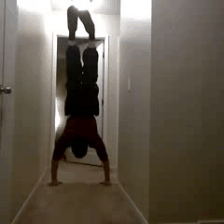

In [ ]:
test_video = np.random.choice(test_df["path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])